<img src="../gfx/euro.png" alt="Euro" style="display: block; margin: auto; width: 100%;" />

<div style="text-align:center"><h1>Détecteur de faux billets - Analyses</h1></div>

**ONCFM - Organisation nationale de lutte contre le faux-monnayage** est une organisation publique ayant pour objectif de mettre en place des méthodes d'identification des contrefaçons des billets en euros.
Dans le cadre de cette lutte, nous souhaitons mettre en place un algorithme qui soit capable de différencier automatiquement les vrais des faux billets.

## Objectifs

Lorsqu'un billet arrive, nous avons une machine qui consigne l'ensemble de ses caractéristiques géométriques. Au fil de nos années de lutte, nous avons observé des différences de dimensions entre les vrais et les faux billets. Ces différences sont difficilement visibles à l'oeil nu, mais une machine devrait sans problème arriver à les différencier.

Ainsi, il faudrait construire un algorithme qui, à partir des caractéristiques géométriques d'un billet, serait capable de définir si ce dernier est un vrai ou un faux billet.

<img src="../gfx/sep.jpg" alt="Barre">

## Chargement

***

In [1]:
# Chargement des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib

sns.color_palette("viridis")
sns.set_theme(style="darkgrid")

from scipy import stats
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import linear_reset
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.stattools import durbin_watson

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, ParameterGrid
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, f1_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.compose import make_column_transformer

np.random.seed(43)

In [2]:
# Chargement des données
df = pd.read_csv("../data/billets.csv", sep=';')
df.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


<img src="../gfx/sep.jpg" alt="Barre">

## 1 - Analyse descriptive

***

### 1.1 - Description du jeu de données

Les données sont composées d'une variable cible : 
- **is_genuine**, détermine si le billet est vrai ou faux (True/False)

In [3]:
df['is_genuine'].value_counts()

is_genuine
True     1000
False     500
Name: count, dtype: int64

Le jeu de données est composé de 1500 billets, répartis de la sorte :
- 1000 vrais billets
- 500 faux billets

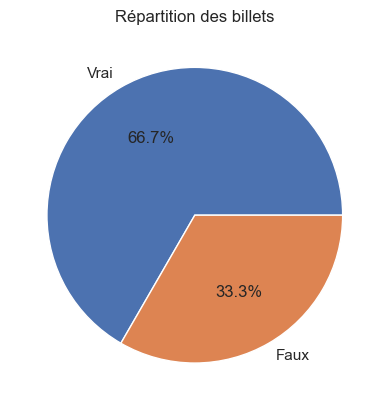

In [4]:
plt.pie(df['is_genuine'].value_counts(), labels=['Vrai', 'Faux'], autopct='%1.1f%%')
plt.title('Répartition des billets')
plt.show()

Les données comportent également 6 variables prédictives, correspondant aux dimensions géométriques des billets :
- **diagonal**, la diagonal du billet (en mm)
- **height_left**, la hauteur du billet mesurée sur le côté gauche (en mm)
- **height_right**, la hauteur du billet mesurée sur le côté droit (en mm)
- **margin_low**, la marge entre le bord inférieur du billet et l'image de celui-ci (en mm)
- **margin_up**, la marge entre le bord supérieur du billet et l'image de celui-ci (en mm)
- **length**, la longueur du billet (en mm)

<img src="../gfx/billet.png" alt="Billet" style="display: block; margin: auto;" />

In [5]:
df.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


In [6]:
# Récupération du dataframe ne comportant que des variables numériques
df_num = df.select_dtypes(include='number')
indicateurs = df_num.columns

### 1.2 - Analyse univariée

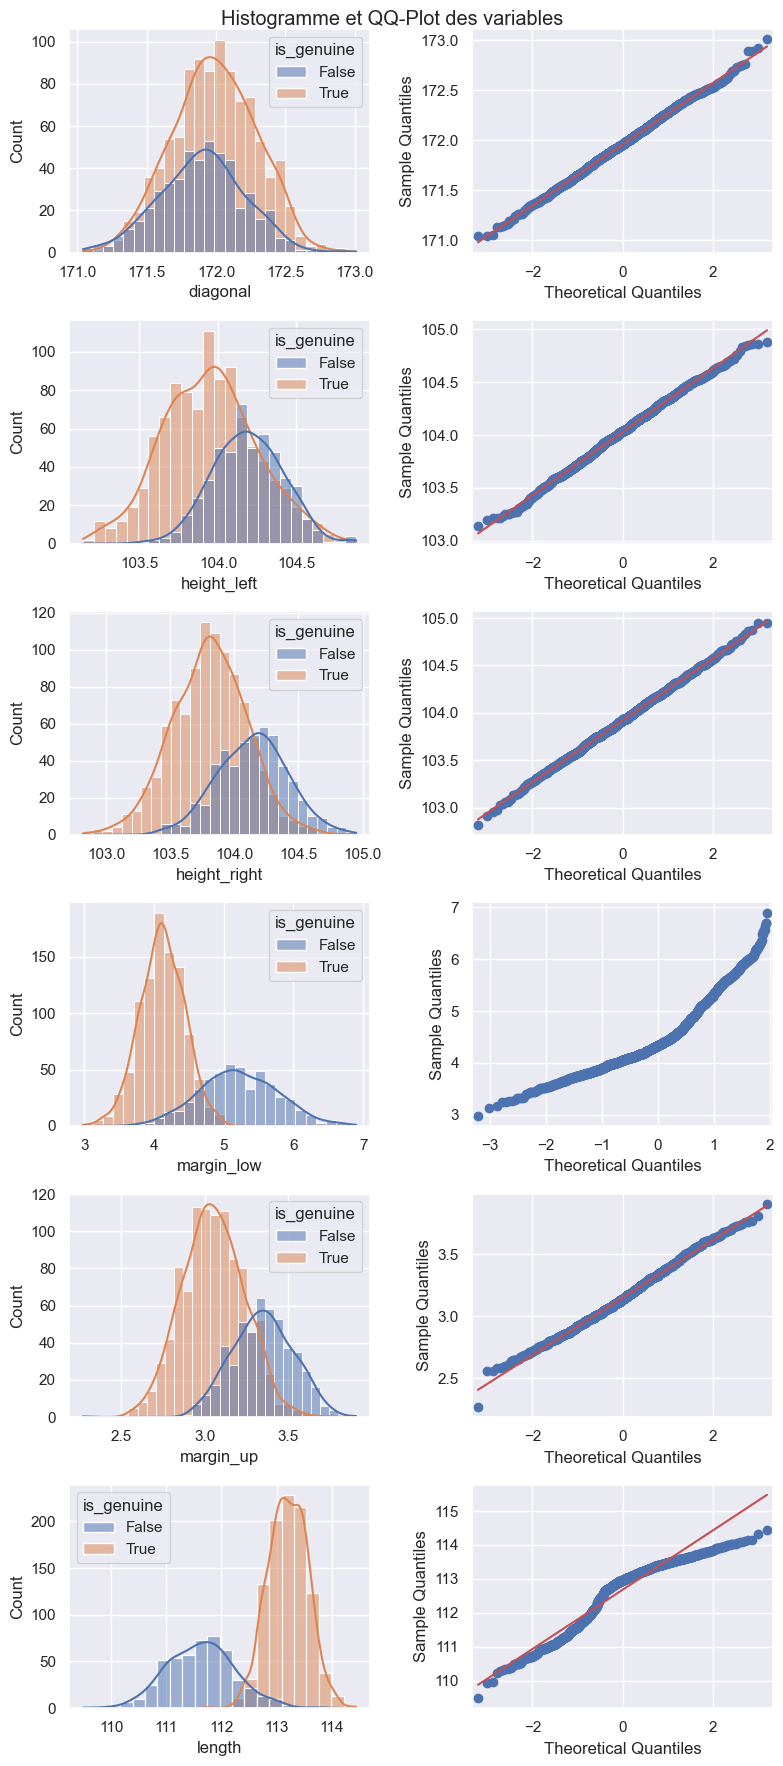

In [7]:
# Test de normalité des variables
fig, axs = plt.subplots(nrows=len(indicateurs), ncols=2, figsize=(8, 3*len(indicateurs)))
plt.subplots_adjust(hspace=0.5)
fig.suptitle('Histogramme et QQ-Plot des variables')

for row in range(len(indicateurs)):
    for col in range(2):
        ax = axs[row, col]
        var = indicateurs[row]
        if col == 0:
            sns.histplot(x=var, data=df, hue='is_genuine', kde=True, ax=ax)
        else:
            qqplot(data=df[var], line='s', ax=ax)

plt.tight_layout()
plt.show()

### 1.3 - Analyse multi-variée

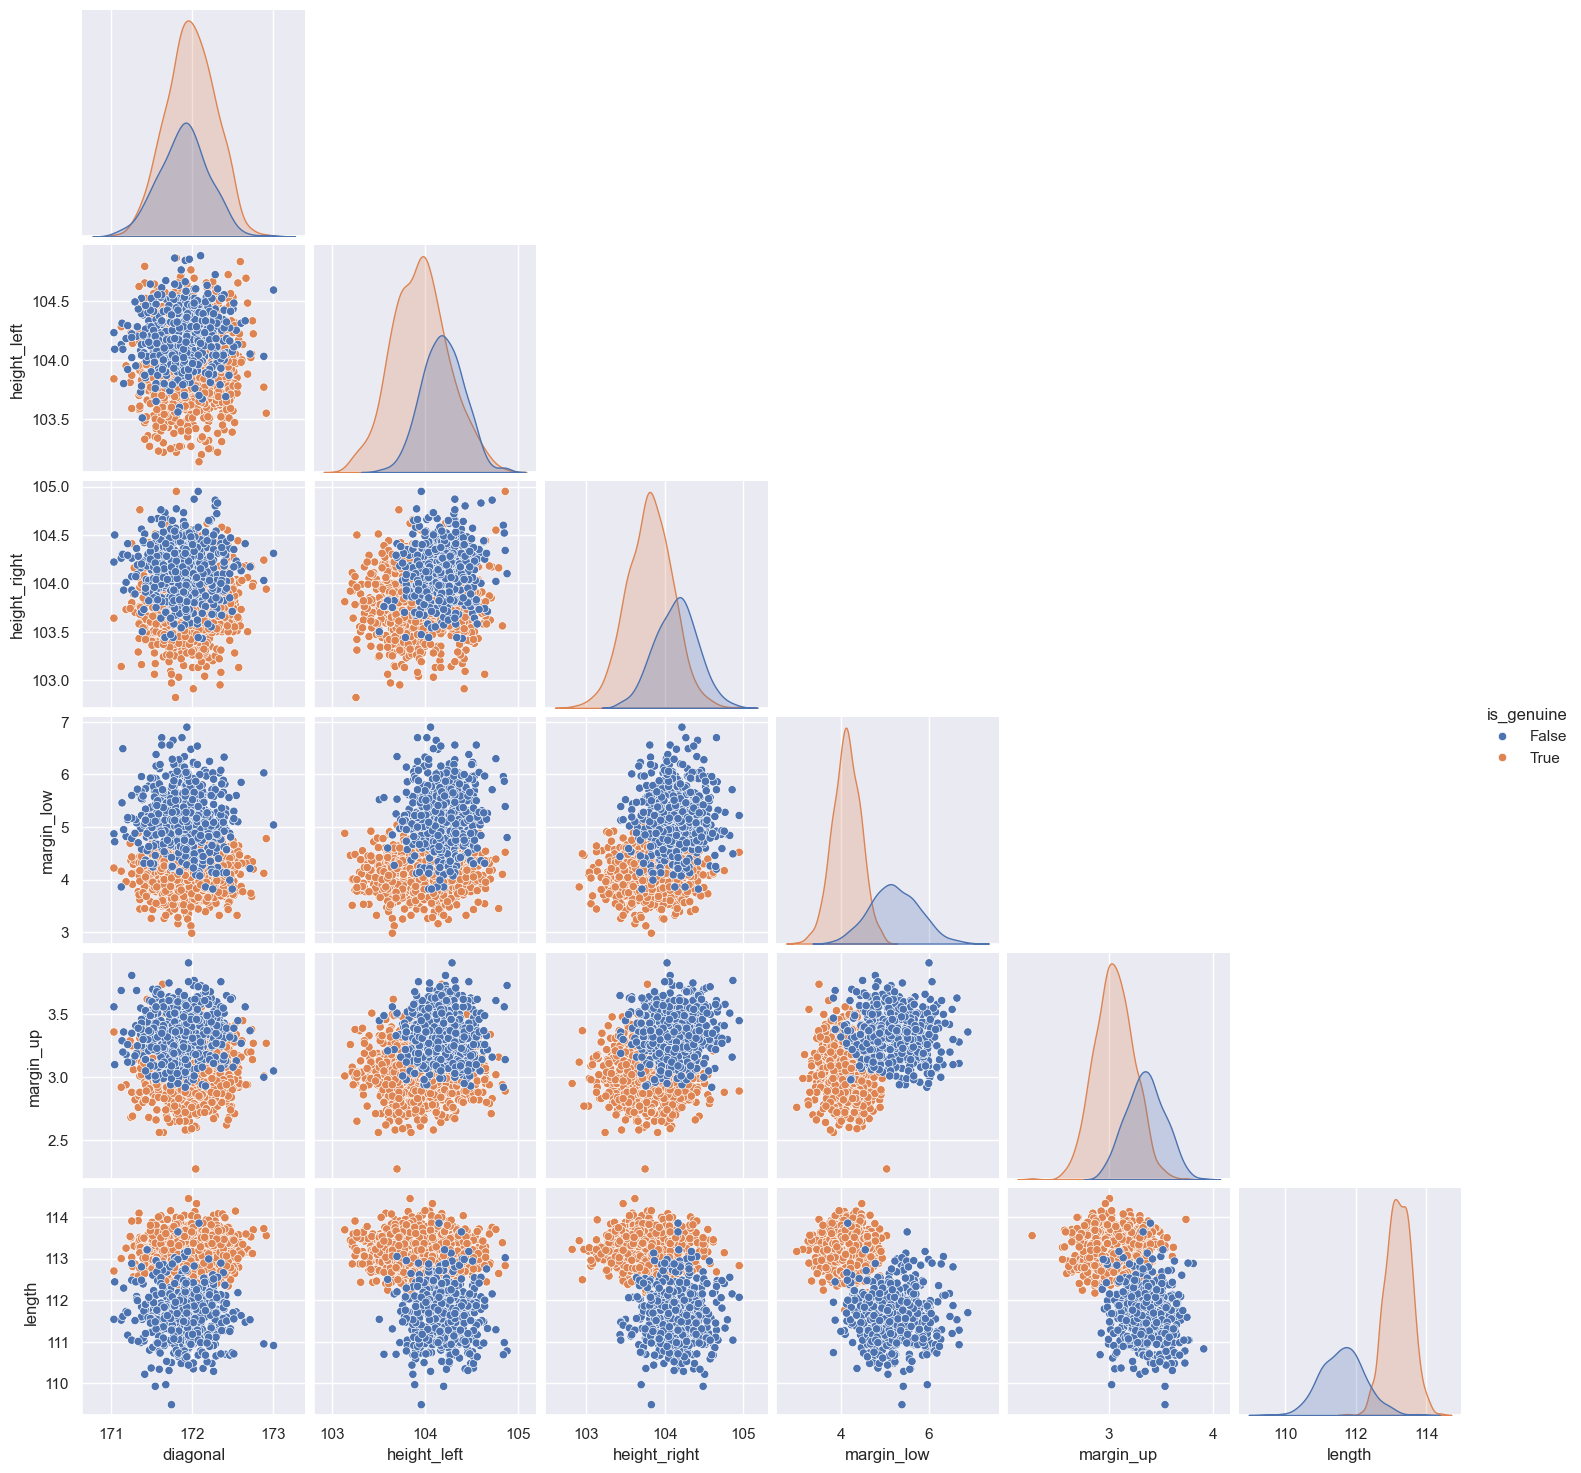

In [8]:
# Graphique par paire
sns.pairplot(df, hue='is_genuine', corner=True)
plt.show()

> Il y a une distinction significative entre les vrais et faux billets sur la variable "length"

> La longueur en relation avec les marges inférieures et supérieures semble être un bon indicateur de la véracité des billets

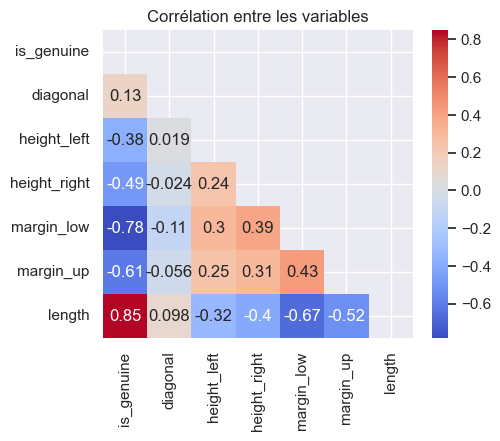

In [9]:
# Analyse des corrélations
correlation = df.corr()
mask = np.triu(np.ones_like(correlation, dtype=bool))
plt.figure(figsize=(5,4))
sns.heatmap(correlation, annot=True, cmap='coolwarm', mask=mask)
plt.title('Corrélation entre les variables')
plt.show()

> L'analyse des corrélations entre les variables semble confirmer l'importance des variables "length", "margin_low" et "margin_up" dans la prédiction de la validité des billets.

### 1.4 - Valeurs manquantes

In [10]:
# Vérification des valeurs manquantes
df.isna().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

> Seule la dimension **margin_low** comporte des valeurs manquantes.

> Il nous faut inférer ces valeurs manquantes à l'aide d'une ***régression linéaire*** à partir des autres variables.

In [11]:
# Copie du dataframe
df_ml = df.copy()

# Codage de la variable 'is_genuine' en variable binaire
df_ml['is_genuine'] = df_ml['is_genuine'].astype('int')
df_ml['is_genuine'].value_counts()

df_mlna = df_ml.copy()
df_ml['is_genuine'].value_counts()

is_genuine
1    1000
0     500
Name: count, dtype: int64

> 1 : Vrai billet

> 0 : Faux billet

In [12]:
# Séparation en 2 dataframes avec les valeurs manquantes et sans valeurs manquantes
df_ml.dropna(subset=['margin_low'], inplace=True)
df_mlna = df_mlna[df_mlna['margin_low'].isna()]

# Vérification des valeurs manquantes
df_ml.isna().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

> Nous pouvons réaliser une ***régression linéaire*** pour prédire les valeurs manquantes pour la variable 'margin_low'.

#### 1.4.1 - Conditions préalables de la régression linéaire

- ***Linéarité***, il doit exister une relation linéaire entre les variables dépendantes et indépendantes.
- ***Normalité***, les résidus doivent être distribués normalement.
- ***Homoscédasticité***, la variance des résidus doit être constante.
- ***Indépendance***, les résidus doivent être indépendants les uns des autres.
- ***Absence de multicolinéarité***, les variables indépendantes ne doivent pas être corrélées entre elles.

#### 1.4.2 - Vérification de la linéarité des relations entre les variables prédictives et la variable cible

In [13]:
# Variables prédictives
predictors = df_ml.columns.tolist()
predictors.remove('margin_low')

# Variable cible
target = 'margin_low'

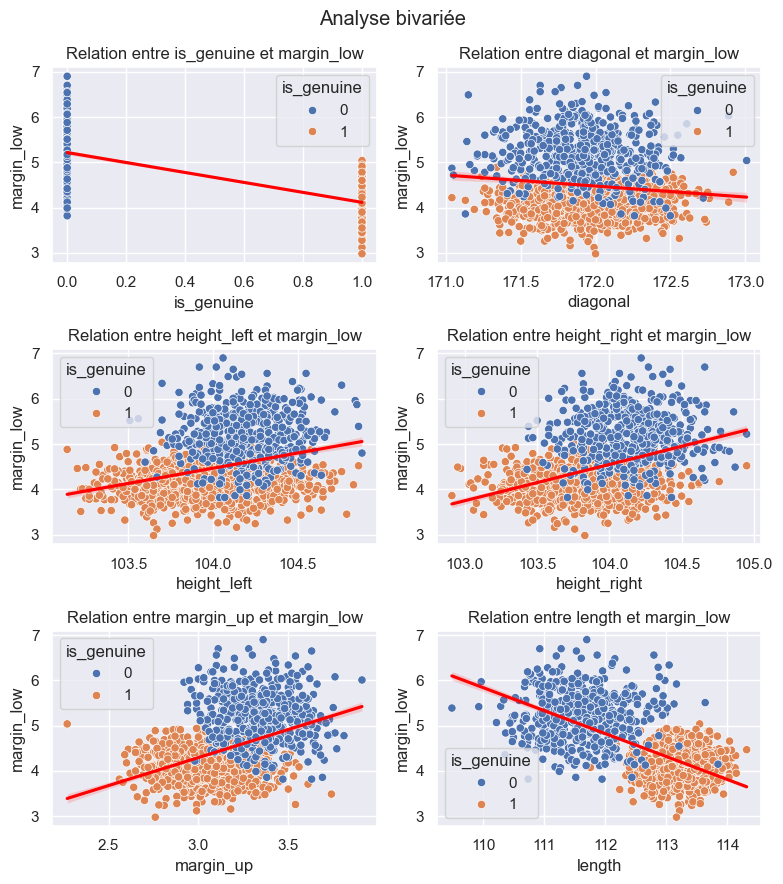

In [14]:
# Analyse bivariée
fig, axs = plt.subplots(nrows=int(np.ceil(len(predictors)/2)), ncols=2, figsize=(8, 3*(len(predictors)/2)))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Analyse bivariée")

for predictor, ax in zip(predictors, axs.ravel()):
    if predictor == target:
        break
    # Scatter plot
    sns.scatterplot(x=predictor, y=target, hue='is_genuine', data=df_ml, ax=ax)
    # Ligne de régression
    model = ols(f"{target} ~ {predictor}", data=df_ml).fit()
    sns.regplot(x=predictor, y=target, data=df_ml, ax=ax, scatter=False, color='red')

    ax.set_title(f"Relation entre {predictor} et {target}")
    ax.set_xlabel(predictor)
    ax.set_ylabel(target)

plt.tight_layout()
plt.show()

> La relation entre les variables est bien linéaire.

In [15]:
# Test RESET de Ramsey
# Objectif : examiner si l'ajout de transformations polynomiales des variables explicatives améliore la qualité du modèle.
# Hypothèse nulle : le modèle est correctement spécifié.
model = ols(f"{target} ~ {' + '.join(df_ml.columns[:-1])}", data=df_ml).fit()
reset = linear_reset(model, use_f=True)
print("Test RESET de Ramsey :")
print("======================")
print("F-Statistic: ", np.round(reset.fvalue, 4))
print("P-Value: ", np.round(reset.pvalue, 4))

Test RESET de Ramsey :
F-Statistic:  0.1428
P-Value:  0.8669


> P-Value supérieur au seuil de 5%.

> On ne rejette pas l'hypothèse nulle de bonne spécification.

> Il n'y a pas de preuve statistique indiquant une erreur de spécification (comme une non-linéarité non capturée, ou une variable omise).

> L'ajout de transformations de variables explicatives n'a pas permis de réduire la variance de l'erreur.

> Il n'y a aucune preuve statistique suggérant que l'inclusion de transformations non linéaires améliore la qualité du modèle.

#### 1.4.3 - Régression Linéaire Multiple

In [16]:
# Variables prédictives
varpred = ['diagonal', 'height_left', 'height_right', 'margin_up', 'length', 'is_genuine']
varprednum = ['diagonal', 'height_left', 'height_right', 'margin_up', 'length']

X_ml = df_ml[varpred]
y_ml = df_ml['margin_low']

In [17]:
# Standardisation des données
# StandardScaler centre et réduit les données
ct = make_column_transformer(
    (StandardScaler(), varprednum),
    remainder='passthrough'
)
ct.fit(X_ml)
X_ml_scaled = ct.transform(X_ml)

df_ml_scaled = pd.DataFrame(X_ml_scaled, columns=varpred)

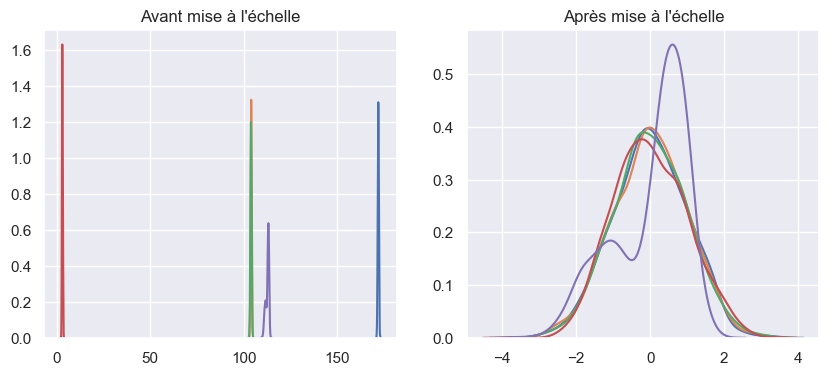

In [18]:
fig, (a,b) = plt.subplots(ncols=2, figsize=(10, 4))

a.set_title("Avant mise à l'échelle")
for col in varprednum:
    sns.kdeplot(df[col], ax=a)
a.set_xlabel("")
a.set_ylabel("")
b.set_title("Après mise à l'échelle")
for col in varprednum:
    sns.kdeplot(df_ml_scaled[col], ax=b)
b.set_xlabel("")
b.set_ylabel("")
plt.show()

In [19]:
# Split des données en train et test
X_ml_train, X_ml_test, y_ml_train, y_ml_test = train_test_split(X_ml_scaled, y_ml, test_size=0.2, random_state=42)

In [20]:
# Entraînement du modèle
reg = LinearRegression()
reg.fit(X_ml_train, y_ml_train)

LinearRegression()

In [21]:
print(f"Intercept : {reg.intercept_}")
print(f"Coefficients : {reg.coef_}")

Intercept : 5.241655908665353
Coefficients : [ 0.00198693  0.00198416  0.00507313 -0.04679589 -0.00247261 -1.14390267]


In [22]:
coef_reglin = pd.DataFrame(
    {
        'Variables': varpred,
        'Coefficients': [reg.coef_[i] for i in range(len(varpred))]
    },
    columns=['Variables', 'Coefficients']
)
coef_reglin.set_index('Variables', inplace=True)

coef_reglin.style.bar(
    subset=['Coefficients'],
    align='mid',
    color=['salmon', 'lightgreen']
).set_properties(**{'border': '0.5px solid black'})

,Coefficients
Variables,
diagonal,0.001987
height_left,0.001984
height_right,0.005073
margin_up,-0.046796
length,-0.002473
is_genuine,-1.143903


> 'is_genuine' la variable sur la véracité des billets, explique presque à lui tout seul la variance de la variable cible 'margin_low'.

> Quasiment aucune action des autres variables, mise à part une faible participation de 'margin_up'.

In [23]:
# Prédiction sur le test set
y_ml_pred = reg.predict(X_ml_test)

#### 1.4.4 - Métriques

In [24]:
# Métriques
print(f"R2, Coefficient de détermination : {r2_score(y_ml_test, y_ml_pred)}")
print(f"RMSE, Racine carré de la moyenne des erreurs au carré : {np.sqrt(mean_squared_error(y_ml_test, y_ml_pred))}")
print(f"MAPE, Moyenne de la valeur absolue des erreurs en pourcentage : {mean_absolute_percentage_error(y_ml_test, y_ml_pred)}")

R2, Coefficient de détermination : 0.6740384594304605
RMSE, Racine carré de la moyenne des erreurs au carré : 0.3706676796239567
MAPE, Moyenne de la valeur absolue des erreurs en pourcentage : 0.06496074172211527


> Nous obtenons un coefficient de détermination de 0.67, ce qui signifie que 67% de la variance de la variable dépendante est expliquée par les variables indépendantes.

In [25]:
# Dataframe des résidus
reg_residus = pd.DataFrame(
    {
        'Observées': y_ml_test,
        'Prédites': y_ml_pred,
        'Résidus': y_ml_test - y_ml_pred,
        'Genuine': X_ml_test[:,5]
    }
)
reg_residus.head()

,Observées,Prédites,Résidus,Genuine
1208,5.19,5.211443,-0.021443,0.0
178,4.26,4.100476,0.159524,1.0
281,4.18,4.117453,0.062547,1.0
561,3.93,4.127238,-0.197238,1.0
891,4.25,4.042756,0.207244,1.0


#### 1.4.5 - Normalité des résidus

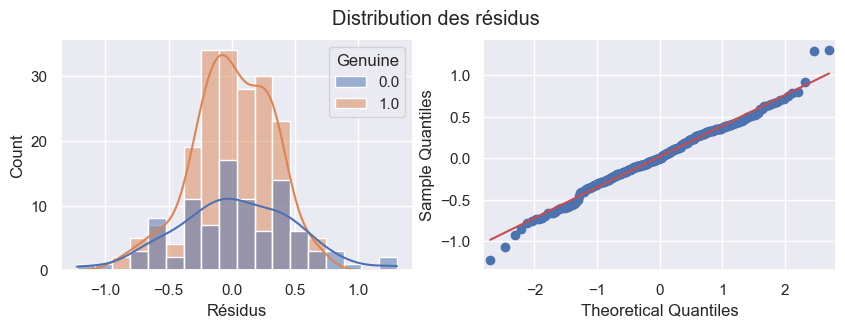

In [26]:
fig, (a,b) = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
plt.suptitle('Distribution des résidus')

sns.histplot(data=reg_residus, x='Résidus', kde=True, hue='Genuine', ax=a)
qqplot(reg_residus['Résidus'], line='s', ax=b)

plt.show()

> Les résidus sont normalement distribués.

#### 1.4.6 - Détection de la multicolinéarité

La multicolinéarité affecte la stabilité et l'interprétabilité des coefficients de régression. Le facteur d'inflation de la variance VIF quantifie la variance d'un coefficient de régression en raison des corrélations entre les variables prédictives.

In [27]:
# Facteur d'inflation de la variance VIF
vif_man = {}

for feature in X_ml.columns:
    y_vif = X_ml[feature]
    X_vif = X_ml.drop(columns=[feature])
    model = LinearRegression().fit(X_vif, y_vif)
    r_squared = model.score(X_vif, y_vif)
    vif = 1 / (1 - r_squared)
    vif_man[feature] = vif

vif_df = pd.DataFrame(list(vif_man.items()), columns=['Variables', 'VIF'])
vif_df

,Variables,VIF
0,diagonal,1.028199
1,height_left,1.173711
2,height_right,1.320836
3,margin_up,1.596090
4,length,3.613255
5,is_genuine,4.725732


> Aucune valeur supérieure à 5, le niveau de multicolinéarité est modéré.

#### 1.4.7 - Homoscédasticité des résidus

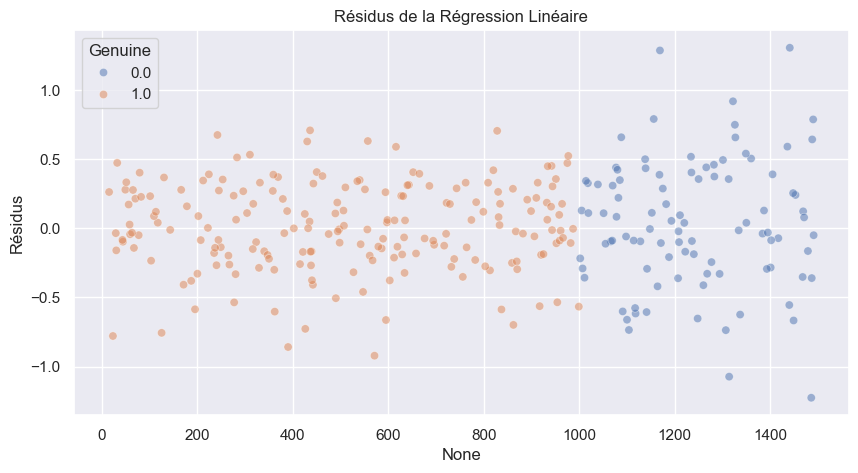

In [28]:
plt.subplots(figsize=(10,5))
sns.scatterplot(x=reg_residus.index, y=reg_residus['Résidus'], hue=reg_residus['Genuine'], alpha=0.5)
plt.title("Résidus de la Régression Linéaire")
plt.show()

> La variance des résidus est constante.

#### 1.4.8 - Indépendance des résidus

In [29]:
# Test de Durbin-Watson
dw_statistic = durbin_watson(reg_residus['Résidus'])
print("Test de Durbin-Watson :")
print("=======================")
print(f"Statistique : {dw_statistic}")

Test de Durbin-Watson :
Statistique : 1.8579139287343662


> Une valeur proche de 2 indique qu'il n'y a pas d'autocorrélation.

#### 1.4.9 - Prédictions des manquants

In [30]:
# Remplacement des manquants de margin_low
ct = make_column_transformer(
    (StandardScaler(), varprednum),
    remainder='passthrough'
)
ct.fit(df_mlna[varpred])
X_mlna_scaled = ct.transform(df_mlna[varpred])

y_mlna_pred = reg.predict(X_mlna_scaled)
df_mlna['margin_low'] = np.round(y_mlna_pred, 2)

In [31]:
# Concaténation des dataframes pour obtenir un dataframe sans manquants
df = pd.concat([df_ml, df_mlna], axis=0)
df_num = df.select_dtypes(include='number')

In [32]:
# Vérification des valeurs manquantes
df.isna().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

In [33]:
df.describe()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.00000
mean,0.666667,171.958440,104.029533,103.920307,4.482507,3.151473,112.67850
std,0.471562,0.305195,0.299462,0.325627,0.659886,0.231813,0.87273
min,0.000000,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,0.000000,171.750000,103.820000,103.710000,4.027500,2.990000,112.03000
50%,1.000000,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,1.000000,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,1.000000,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


> Les valeurs pour margin_low sont très proches des valeurs d'avant la régression linéaire.

### 1.5 - Valeurs aberrantes ou atypiques

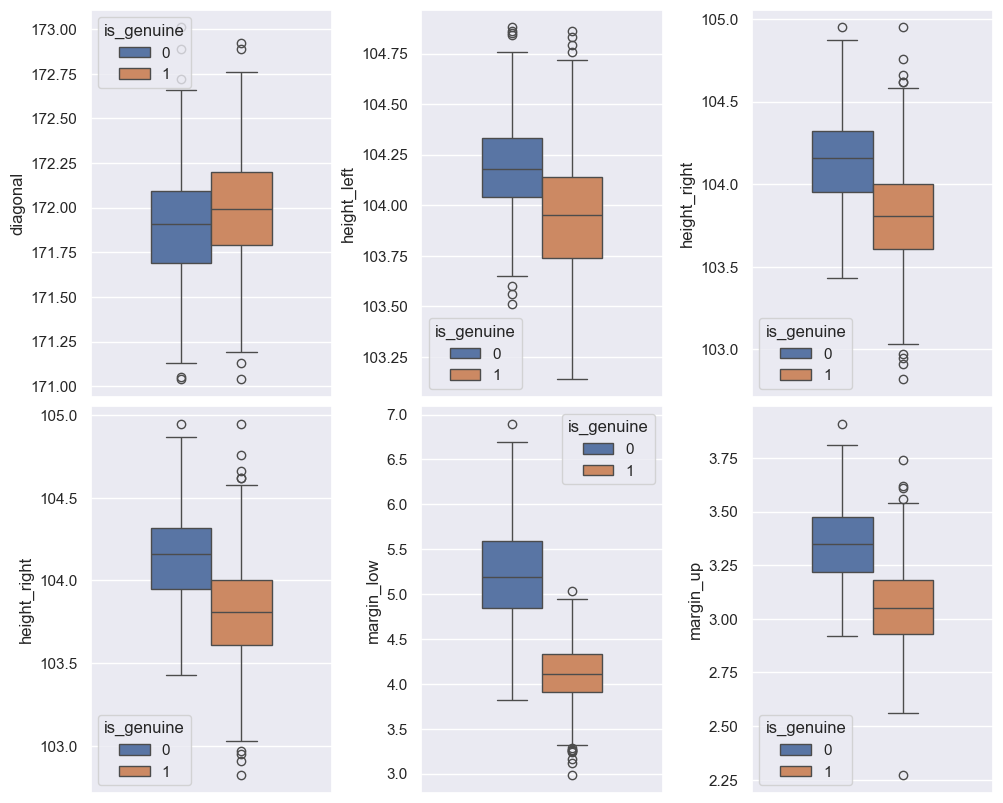

In [34]:
# Répartition des dimensions des billets
fig, axs = plt.subplots(nrows=int(len(indicateurs)/3), ncols=3, figsize=(int(len(indicateurs)/3)*5,8))

for row in range(int(len(indicateurs)/3)):
    for col in range(3):
        i = row*int(len(indicateurs)/3)+col
        ax = axs[row, col]
        sns.boxplot(hue=df_num['is_genuine'], y=df_num[indicateurs[i]], data=df_num, ax=ax, width=0.5)

fig.tight_layout(pad=0.5)
plt.show()

> Les plus grandes différences de distribution sont observées pour les dimensions ***"length", "margin_low" et "margin_up"***.

In [35]:
# Copie du dataframe pour vérification par stats
df_stats = df_num.copy()
z_indicateurs = ['z_diagonal', 'z_height_left', 'z_height_right', 'z_margin_low', 'z_margin_up', 'z_length']

# Vérification avec le Z-Score
# Z-Score : mesure standardisée de la distance entre une valeur et la moyenne divisée par l'écart-type
df_stats['z_diagonal'] = stats.zscore(df_stats.diagonal)
df_stats['z_height_left'] = stats.zscore(df_stats.height_left)
df_stats['z_height_right'] = stats.zscore(df_stats.height_right)
df_stats['z_margin_low'] = stats.zscore(df_stats.margin_low)
df_stats['z_margin_up'] = stats.zscore(df_stats.margin_up)
df_stats['z_length'] = stats.zscore(df_stats.length)

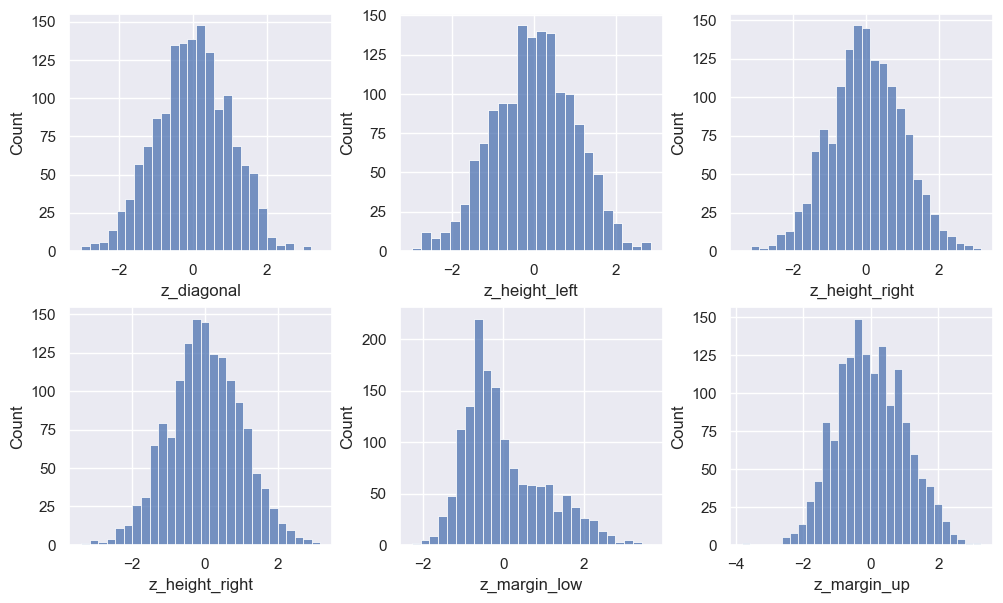

In [36]:
# Histogramme des Z-Scores
fig, axs = plt.subplots(nrows=int(len(indicateurs)/3), ncols=3, figsize=(int(len(indicateurs)/3)*5,6))

for row in range(int(len(indicateurs)/3)):
    for col in range(3):
        i = row*int(len(indicateurs)/3)+col
        ax = axs[row, col]
        sns.histplot(data=df_stats[z_indicateurs[i]], ax=ax)

fig.tight_layout(pad=0.5)
plt.show()

> La plupart des valeurs sont à moins de 2 écarts-type de la moyenne.

> Quelques valeurs sont à plus de 2 écarts-type de la moyenne. Mais aucune au delà de 3 écarts-type.

> Les données dimensionnelles ne comportent ***pas de valeurs aberrantes ou atypiques***.

### 1.6 - Résumé du jeu de données

In [37]:
df_num.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1500 entries, 0 to 1438
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   int64  
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1500 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 93.8 KB


> 1500 échantillons

> 1 variable cible binaire (0 : faux billet, 1 : vrai billet)

> 6 variables prédictives

<img src="../gfx/sep.jpg" alt="Barre">

## 2 - Test des modèles

***

### 2.1 - Préparation des données

In [38]:
X = df_num.drop(columns=['is_genuine'])
y = df_num['is_genuine']

# Division
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardisation des données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_scaled = scaler.transform(X)

### 2.2 - Définition des modèles et hyperparamètres

- ***Régression Logistique :*** technique de classification supervisée, utilisée pour prédire la probabilité d'appartenance à une classe.
- ***K-Means :*** technique non supervisée de clustering, permettant de regrouper les données en fonction de leurs similarités.
- ***K-Nearest Neighbors :*** technique de classification supervisée, utilisée pour prédire la classe d'un nouvel échantillon en se basant sur les classes des k échantillons les plus proches.
- ***Arbre de décision :*** technique de classification supervisée, utilisée pour construire un modèle de décision basé sur un ensemble d'attributs.
- ***Forêt aléatoire :*** technique de classification supervisée, utilisée pour construire un modèle de décision basé sur un ensemble d'arbres de décision.
- ***Gradient Boosting :*** technique de classification supervisée, similaire à la forêt aléatoire mais avec une approche séquentielle et adaptative.
- ***Support Vector Machine :*** technique de classification supervisée, visant à trouver la frontière de décision optimale pour séparer les classes.
- ***Multi-Layer Perceptron :*** technique de classification supervisée, utilisée pour construire un modèle de réseau de neurones artificiels.

In [39]:
# Modèles de classification
modeles = {
    'Régression Logistique': LogisticRegression(),
    'K-Means': KMeans(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Arbre de décision': DecisionTreeClassifier(),
    'Forêt aléatoire': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Support Vector Machine': SVC(),
    'Multi-Layer Perceptron': MLPClassifier()
}

modeles_noms = list(modeles.keys())

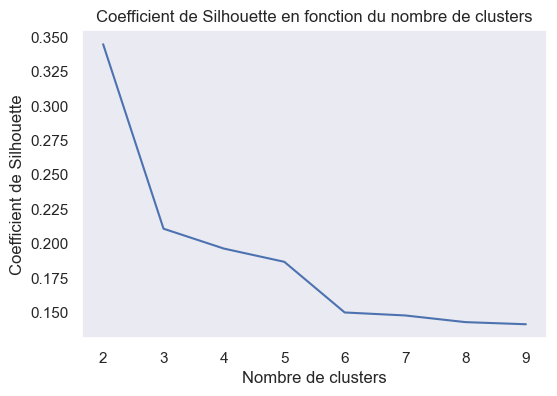

In [40]:
# Détermination du nombre de clusters optimal pour le KMeans avec le coefficient de silhouette
silhouette_scores = []
for n_clusters in range(2, 10):
    kms = KMeans(init="k-means++", n_clusters=n_clusters, random_state=42, n_init='auto')
    kms.fit(X_scaled)
    kms_labels = kms.predict(X_scaled)
    silhouette_scores.append(silhouette_score(X_scaled, kms_labels))

fig, ax = plt.subplots(figsize=(6,4))
plt.plot(range(2, 10), silhouette_scores)
plt.xlabel('Nombre de clusters')
plt.ylabel('Coefficient de Silhouette')
plt.title('Coefficient de Silhouette en fonction du nombre de clusters')
plt.grid()
plt.show()

> Nous avons un pic du coefficient de Silhouette pour ***2 clusters***.

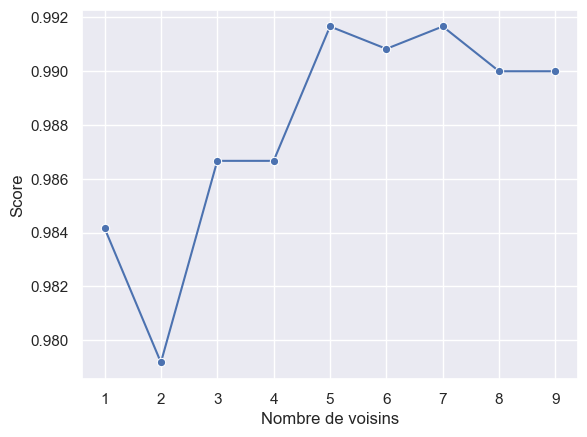

In [41]:
# Détermination du nombre de voisins optimal pour le K-Nearest Neighbors
scores = []

for k in range(1, 10):
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X_train_scaled, y_train, cv=10)
    scores.append(np.mean(score))

sns.lineplot(x=range(1, 10), y=scores, marker='o')
plt.xlabel('Nombre de voisins')
plt.ylabel('Score')
plt.show()

> Nous obtenons le meilleur score avec 5 voisins

In [42]:
# Hyperparamètres
hyperparametres = {
    'Régression Logistique' : {
        'C': np.logspace(-3, 3, 7),
        'penalty': ['l2'],
        'max_iter': range(100, 500),
        'solver': ['lbfgs', 'newton-cg', 'liblinear'],
        'warm_start': [True, False]
    },
    'K-Means' : {
        'n_clusters': [2],
        'init': ['k-means++'],
        'n_init': ['auto'],
        'random_state': [42],
    },
    'K-Nearest Neighbors' : {
        'n_neighbors': [5],
        'weights': ['uniform', 'distance'],
        'algorithm': ['ball_tree', 'kd_tree', 'brute']
    },
    'Arbre de décision' : {
        'max_depth': list(range(1, 10, 1)),
        'min_samples_split': list(range(2, 10, 1)),
        'min_samples_leaf': list(range(1, 10, 1)),
        'max_features': ['sqrt', 'log2']
    },
    'Forêt aléatoire' : {
        'n_estimators': list(range(10, 100, 10)),
        'max_depth': list(range(1, 10, 1)),
        'min_samples_split': list(range(2, 10, 1)),
        'min_samples_leaf': list(range(1, 10, 1)),
        'max_features': ['sqrt', 'log2'],
        'bootstrap': [True, False]
    },
    'Gradient Boosting' : {
        'n_estimators': list(range(10, 100, 10)),
        'learning_rate': np.logspace(-3, 3, 7),
        'max_depth': list(range(1, 11, 1)),
        'min_samples_split': list(range(2, 10, 1)),
        'min_samples_leaf': list(range(1, 10, 1)),
        'max_features': ['sqrt', 'log2'],
        'loss': ['log_loss', 'exponential']
    },
    'Support Vector Machine' : {
        'C': np.logspace(-3, 3, 7),
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'degree': range(1, 10),
        'gamma': ['scale', 'auto'],
        'coef0': range(0, 10),
        'shrinking': [True, False],
        'probability': [True, False],
        'tol': [1e-3],
        'decision_function_shape': ['ovr'],
    },
    'Multi-Layer Perceptron' : {
        'hidden_layer_sizes': [(10,), (50,), (100,)],
        'activation': ['identity', 'logistic', 'tanh', 'relu'],
        'solver': ['lbfgs', 'sgd', 'adam'],
        'alpha': [0.0001, 0.05],
        'learning_rate': ['constant', 'invscaling', 'adaptive'],
        'max_iter': [1000],
        'random_state': [42]
    }
}

### 2.3 - Entraînement des modèles

In [43]:
acc, cms, prec, rec, f1, roc, roccurve, probas, params, models, preds, score_train, score_test, fits, train_time, pred_time = ([] for i in range(16))

for nom, modele in modeles.items():
    pg = ParameterGrid(hyperparametres[nom])
    nb_fits = 50
    if hyperparametres[nom]:
        if nom == "K-Means" or nom == "K-Nearest Neighbors":
            rand_search = GridSearchCV(modele, hyperparametres[nom], cv=5, n_jobs=-1, verbose=0)
            nb_fits = len(pg)*5
            start_time = time.time()
            if nom == "K-Means":
                rand_search.fit(X_train_scaled)
            else:
                rand_search.fit(X_train_scaled, y_train)
        else:
            rand_search = RandomizedSearchCV(modele, hyperparametres[nom], cv=5, n_jobs=-1, verbose=0, random_state=42)
            start_time = time.time()
            rand_search.fit(X_train_scaled, y_train)
        end_time = time.time()
        train_time.append((end_time - start_time)/nb_fits)
        best_model = rand_search.best_estimator_
    else:
        best_model = modele.fit(X_train_scaled, y_train)
    fits.append(nb_fits)

    start_time = time.time()
    pred = best_model.predict(X_test_scaled)
    end_time = time.time()
    pred_time.append(end_time - start_time)
    test = y_test

    if nom == "K-Means":
        # KMeans étant un algorithme de clustering non-supervisé, on ne peut pas calculer la probabilité de prédiction
        # On utilise donc la distance moyenne entre les points et le centre du cluster
        mean_cluster_0 = y_test[pred == 0].mean()
        mean_cluster_1 = y_test[pred == 1].mean()
        if mean_cluster_0 > mean_cluster_1:
            positive_cluster = 0
        else:
            positive_cluster = 1
        distances = np.array([np.linalg.norm(x - best_model.cluster_centers_[cluster]) for x, cluster in zip(X_test_scaled, pred)])
        proba = np.where(pred == positive_cluster, distances, -distances)
    else:
        proba = best_model.predict_proba(X_test_scaled)[:, 1]

    acc.append(accuracy_score(test, pred))
    cms.append(confusion_matrix(test, pred))
    prec.append(precision_score(test, pred, average='weighted'))
    rec.append(recall_score(test, pred, average='weighted', zero_division=0))
    f1.append(f1_score(test, pred, average='weighted'))
    roc.append(roc_auc_score(test, pred))
    roccurve.append(roc_curve(test, proba))
    probas.append(proba)
    params.append(rand_search.best_params_)
    models.append(best_model)
    preds.append(pred)
    if nom == "K-Means":
        score_train.append(' ')
        score_test.append(' ')
    else:
        score_train.append(best_model.score(X_train_scaled, y_train))
        score_test.append(best_model.score(X_test_scaled, y_test))

In [44]:
process_hyper = pd.DataFrame(
    {
        'Modèles': modeles_noms,
        'Nombre de fits': fits,
        "Temps d'entraînement par fit (s)": train_time,
        "Temps de prédiction (s)": pred_time
    },
    columns=['Modèles', 'Nombre de fits', "Temps d'entraînement par fit (s)", "Temps de prédiction (s)"]
)
process_hyper.style.background_gradient(
        axis = 0,
        cmap = 'YlGnBu'
    )

,Modèles,Nombre de fits,Temps d'entraînement par fit (s),Temps de prédiction (s)
0,Régression Logistique,50,0.050290,0.000072
1,K-Means,5,0.020034,0.000278
2,K-Nearest Neighbors,30,0.004695,0.005293
3,Arbre de décision,50,0.001868,0.000060
4,Forêt aléatoire,50,0.008207,0.001612
5,Gradient Boosting,50,0.006424,0.000284
6,Support Vector Machine,50,0.003636,0.002092
7,Multi-Layer Perceptron,50,0.039353,0.000117


In [45]:
best_params = pd.DataFrame(
    {
        'Modèles': modeles_noms,
        'Meilleurs paramètres': params
    }
)
with pd.option_context('display.max_colwidth', 400):
    display(best_params)

,Modèles,Meilleurs paramètres
0,Régression Logistique,"{'warm_start': True, 'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 437, 'C': 0.01}"
1,K-Means,"{'init': 'k-means++', 'n_clusters': 2, 'n_init': 'auto', 'random_state': 42}"
2,K-Nearest Neighbors,"{'algorithm': 'ball_tree', 'n_neighbors': 5, 'weights': 'uniform'}"
3,Arbre de décision,"{'min_samples_split': 4, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 4}"
4,Forêt aléatoire,"{'n_estimators': 90, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 5, 'bootstrap': True}"
5,Gradient Boosting,"{'n_estimators': 50, 'min_samples_split': 4, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'max_depth': 3, 'loss': 'log_loss', 'learning_rate': 0.1}"
6,Support Vector Machine,"{'tol': 0.001, 'shrinking': False, 'probability': True, 'kernel': 'rbf', 'gamma': 'auto', 'degree': 7, 'decision_function_shape': 'ovr', 'coef0': 1, 'C': 0.1}"
7,Multi-Layer Perceptron,"{'solver': 'adam', 'random_state': 42, 'max_iter': 1000, 'learning_rate': 'constant', 'hidden_layer_sizes': (100,), 'alpha': 0.0001, 'activation': 'relu'}"


### 2.4 - Evaluation des modèles

In [46]:
# Tableau des métriques
metriques = pd.DataFrame(
    {
        'Modèles': list(modeles.keys()),
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-score': f1,
        'ROC-AUC': roc,
        'Score Train': score_train,
        'Score Test': score_test
    },
    columns=['Modèles', 'Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC', 'Score Train', 'Score Test']
)

metriques.style.background_gradient(
        axis = 0,
        cmap = 'YlGnBu'
    )

,Modèles,Accuracy,Precision,Recall,F1-score,ROC-AUC,Score Train,Score Test
0,Régression Logistique,0.986667,0.986808,0.986667,0.986691,0.987559,0.990833,0.986667
1,K-Means,0.973333,0.973333,0.973333,0.973333,0.971400,,
2,K-Nearest Neighbors,0.990000,0.990005,0.990000,0.989991,0.988345,0.991667,0.990000
3,Arbre de décision,0.966667,0.967262,0.966667,0.966783,0.967968,0.975000,0.966667
4,Forêt aléatoire,0.993333,0.993333,0.993333,0.993333,0.992850,0.992500,0.993333
5,Gradient Boosting,0.986667,0.986667,0.986667,0.986667,0.985700,0.997500,0.986667
6,Support Vector Machine,0.990000,0.990005,0.990000,0.989991,0.988345,0.993333,0.990000
7,Multi-Layer Perceptron,0.993333,0.993333,0.993333,0.993333,0.992850,0.992500,0.993333


- ***Accuracy :*** rapport entre le nombre de prédictions correctes et le nombre total de prédictions.
- ***Precision :*** rapport entre les positifs correctement identifiés (vrais positifs) et tous les positifs identifés.
- ***Recall :*** rapport entre les positifs correctement identifiés (vrais positifs) et tous les positifs réels.
- ***F1-score :*** moyenne harmonique entre Precision et Recall.
- ***ROC-AUC :*** aire sous la courbe ROC (trace le taux de vrais positifs en fonction du taux de faux positifs).

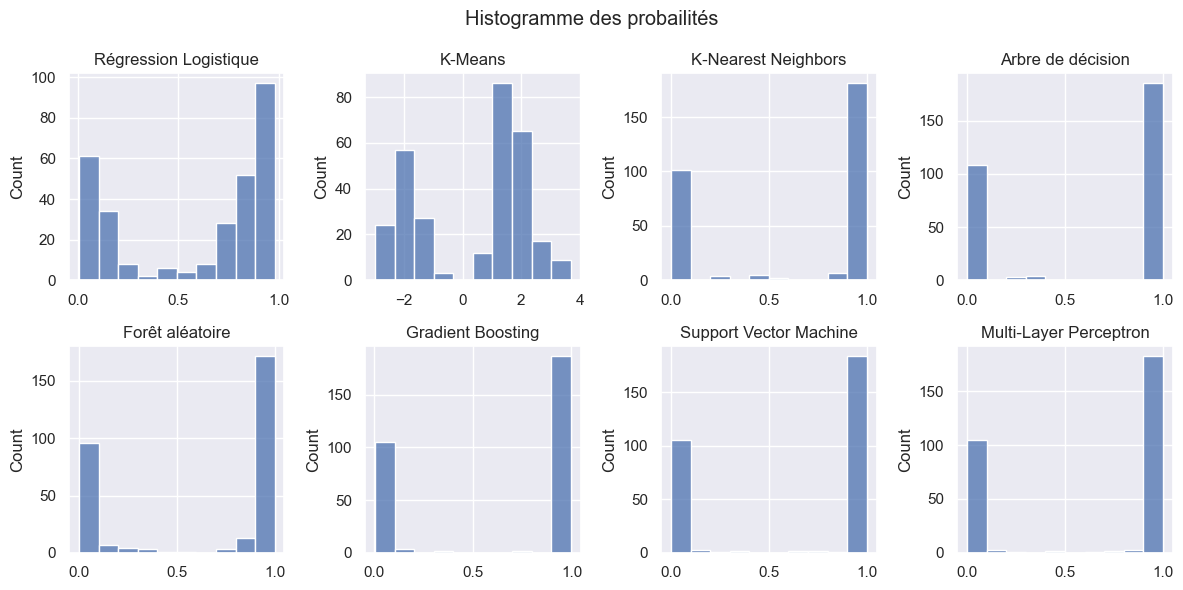

In [47]:
# Histogramme des probabilités
nbrows = 2
fig, axs = plt.subplots(nrows=nbrows, ncols=int(np.ceil(len(modeles)/nbrows)), figsize=(np.ceil(len(modeles)/nbrows)*3, 6))
fig.suptitle("Histogramme des probailités")

for row in range(nbrows):
    for col in range(int(np.ceil(len(modeles)/nbrows))):
        i = row*int(np.ceil(len(modeles)/nbrows)) + col
        ax = axs[row, col]
        sns.histplot(probas[i], ax=ax)
        ax.set_title(modeles_noms[i])

plt.tight_layout()
plt.show()

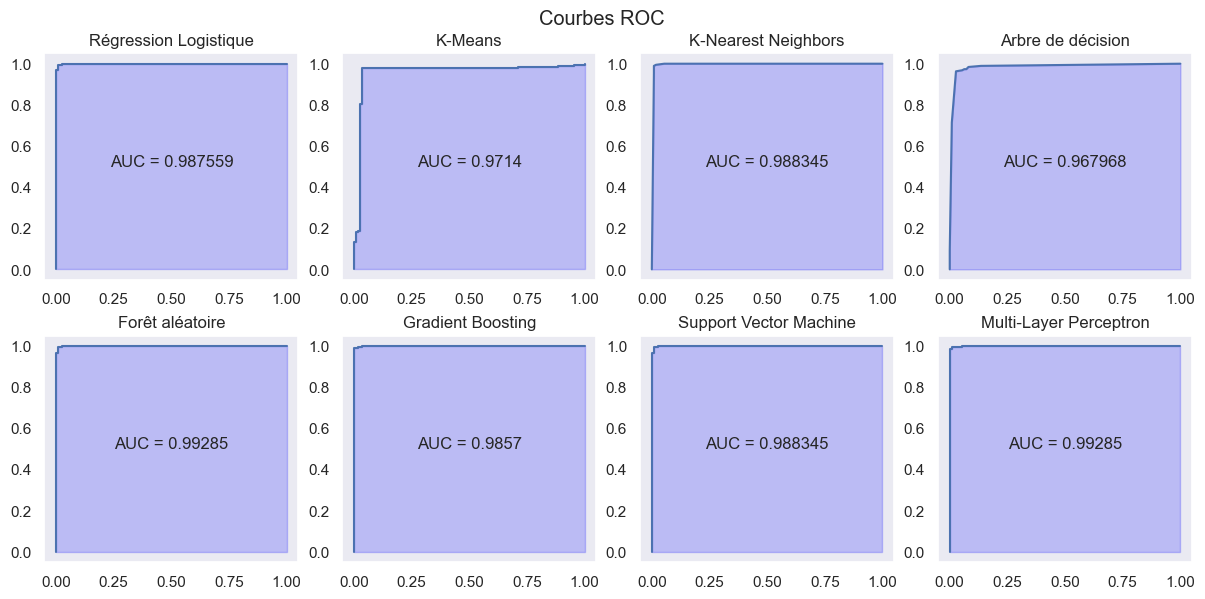

In [48]:
# Courbes ROC
fig, axs = plt.subplots(ncols=int(np.ceil(len(modeles)/nbrows)), nrows=nbrows, figsize=(np.ceil(len(modeles)/nbrows)*3, 6))
fig.suptitle("Courbes ROC")

for row in range(nbrows):
    for col in range(int(np.ceil(len(modeles)/nbrows))):
        i = row*int(np.ceil(len(modeles)/nbrows)) + col
        ax = axs[row, col]

        fpr, tpr, thresholds = roccurve[i]

        ax.plot(fpr, tpr)
        ax.fill_between(fpr, tpr, 0, color='blue', alpha=0.2)
        ax.text(0.5, 0.5, f"AUC = {np.round(roc[i], 6)}", horizontalalignment='center')
        ax.grid()
        ax.set_title(modeles_noms[i])

fig.tight_layout(pad=0.5)
plt.show()

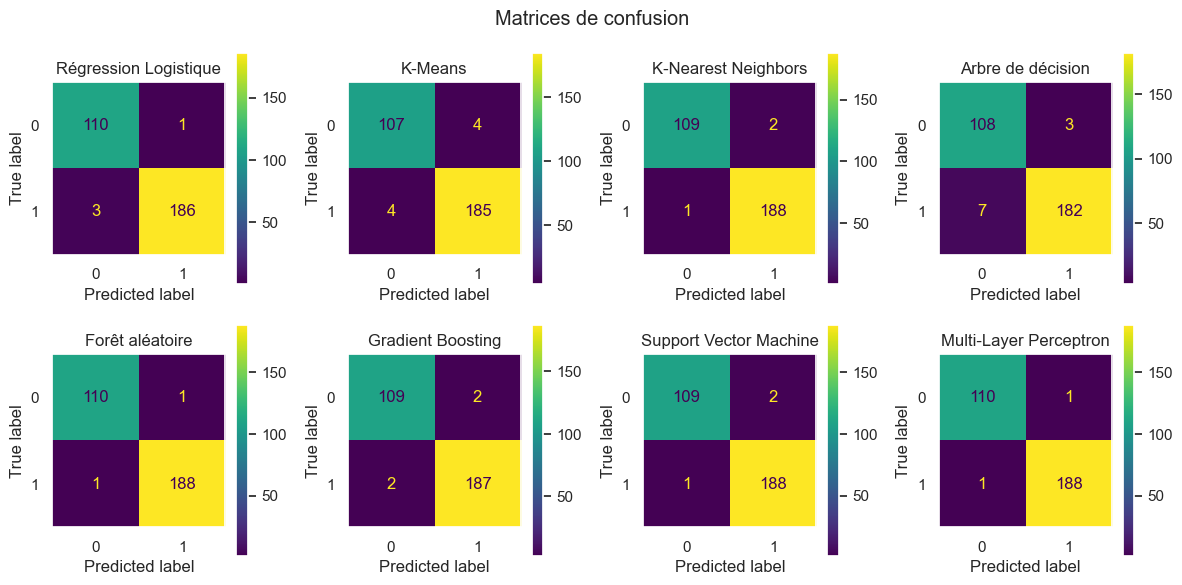

In [49]:
# Matrices de confusion
fig, axs = plt.subplots(nrows=nbrows, ncols=int(np.ceil(len(modeles)/nbrows)), figsize=(np.ceil(len(modeles)/nbrows)*3, 6))
fig.suptitle("Matrices de confusion")

for row in range(nbrows):
    for col in range(int(np.ceil(len(modeles)/nbrows))):
        i = row*int(np.ceil(len(modeles)/nbrows)) + col
        ax = axs[row, col]
        disp = ConfusionMatrixDisplay(confusion_matrix=cms[i], display_labels=[0,1])
        disp.plot(ax=ax)
        ax.grid(None)
        ax.set_title(modeles_noms[i])

plt.tight_layout()
plt.show()

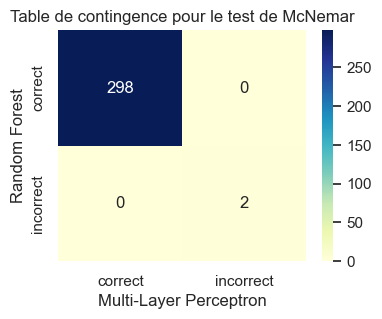

In [50]:
# Test de McNemar pour départager la Forêt aléatoire et le Multii-Layer Perceptron
rf_index = 4
mlp_index = 7

y_pred_rf = preds[rf_index]
y_pred_mlp = preds[mlp_index]

correct_rf = (y_pred_rf == y_test)
correct_mlp = (y_pred_mlp == y_test)

# Construction de la table de contingence, organisée comme suit:
#                     MLP correct     MLP incorrect
# RF correct               a                b
# RF incorrect             c                d
a = np.sum(np.logical_and(correct_rf, correct_mlp))     # MLP et RF corrects
b = np.sum(np.logical_and(correct_rf, ~correct_mlp))    # Seul le Random Forest est correct
c = np.sum(np.logical_and(~correct_rf, correct_mlp))    # Seul le MLP est correct
d = np.sum(np.logical_and(~correct_rf, ~correct_mlp))   # MLP et RF incorrects

table = np.array([[a, b], [c, d]])

fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(111)
sns.heatmap(table, annot=True, fmt="d", cmap='YlGnBu', ax=ax)
ax.set_title("Table de contingence pour le test de McNemar")
ax.set_xlabel("Multi-Layer Perceptron")
ax.set_xticklabels(["correct", "incorrect"])
ax.set_yticklabels(["correct", "incorrect"])
ax.set_ylabel("Random Forest")
plt.show()


> Il n'est pas possible de départager ces 2 modèles de classification avec le test de McNemar.

### 2.5 - Choix du modèle

**Etant donné que d'après notre jeu de données, nous avons 2 modèles avec des résultats strictement identiques, nous devons choisir notre modèle de production en fonction d'autres critères.**

#### 2.5.1 - Temps d'entraînement et de prédiction

In [51]:
process_time = pd.DataFrame(
    {
        'Modèles': [modeles_noms[rf_index], modeles_noms[mlp_index]],
        "Temps d'entraînement (s) par fit": [train_time[rf_index], train_time[mlp_index]],
        "Temps de prédiction (s)": [pred_time[rf_index], pred_time[mlp_index]]
    },
    columns=['Modèles', 'Temps d\'entraînement (s) par fit', 'Temps de prédiction (s)']
)
process_time.style.background_gradient(
        axis = 0,
        cmap = 'YlGnBu'
    )

,Modèles,Temps d'entraînement (s) par fit,Temps de prédiction (s)
0,Forêt aléatoire,0.008207,0.001612
1,Multi-Layer Perceptron,0.039353,0.000117


Temps d'entraînement exprimé par fit.

Temps de prédiction exprimé pour un jeu de 300 données.

> Random Forest est plus rapide à entraîner que Multi-Layer Perceptron.

> Mais Multi-Layer Perceptron est plus rapide sur la prédiction.

#### 2.5.2 - Interprétabilité

> Le Random Forest offre généralement des outils qui facilitent l'explication des décisions du modèle.

> Le Multi-Layer Perceptron, étant un modèle de réseau de neurones, est souvent considéré comme une "boîte-noire", ce qui signifie qu'il peut être difficile d'interpréter les décisions du modèle.

#### 2.5.3 - Capacité de régularisation et risque de surapprentissage

> Le Multi-Layer Perceptron peut parfois surapprendre si la régulatisation n'est pas correctement appliquée.

> Le Random Forest, grâce à la moyenne sur plusieurs arbres, a souvent une meilleure résistance au surapprentissage.

#### 2.5.4 - Complexité de l'implémentation et réglage des hyperparamètres

> Random Forest comporte 19 paramètres.

> Multi-Layer Perceptron comporte 23 paramètres.

#### 2.5.5 - Robustesse et généralisation

> Ce point ne sera pas traîté dans ce projet.

#### 2.5.6 - Scalabilité et maintenance

> Ce point ne sera pas traîté dans ce projet.

<img src="../gfx/sep.jpg" alt="Barre">

## 3 - Sauvegarde du modèle sélectionné pour la production

***

Même s'il est difficile de départager les 2 modèles les plus performants, Random Forest est choisi pour la mise en production.

In [52]:
le_modele = models[rf_index]
version = '1.0'
joblib.dump(le_modele, f"le_modele_{version}.pkl")

['le_modele_1.0.pkl']

 <img src="../gfx/sep.jpg" alt="Barre">